# <center>Uso de LSTM NN for Timeseries datasets</center>
# <center>Multivariate & Multistep</center>

Multivariate => we forecast one feature in the future, by training with that feature observations in the past + other features observations in the past. In this case temperature, pressure and humidity

Multistep => we forecast not only 1 point in the future but all from now to that point. In this case from 1h to 12h in the future

Dataset used "jena_climate_2009_2016.csv"

<a name="id8"></a>
**Networks under study:**

1. [LSTM 1x32N](#id1)
2. [Dense 1x32N](#id2)
3. [LSTM 3x128N](#id3)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks")
!ls

from Rober_library import plotHistory, Optimize_parameters_RegrNN_BF, Create_Train_RegrNN, Optimize_all_MLmodels

Mounted at /content/drive/
'best_model 30 64.h5'			'Neural Net telecust uso de GPU.ipynb'
 best_model.h5				'NN hiperparametros II.ipynb'
'Importar Rober_library Colab.ipynb'	 __pycache__
 jena_climate_2009_2016.csv		 Rober_library.ipynb
'LSTM NN multivariate multistep.ipynb'	 Rober_library.py
'LSTM univariate.ipynb'


In [3]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
df.head()

Date Time  p (mbar)  T (degC)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02  ...      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41  ...      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51  ...      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31  ...      0.34           0.50     198.0
4  01.01.2009 00:50:00    996.51     -8.27  ...      0.32           0.63     214.3

[5 rows x 15 columns]

In [5]:
# Sub-sampling: 1 every 6
# We go from 420.000 samples, 1 every 10 min, to 70.000 samples, 1 per hour
step = 6
a = range(0,len(df),step)

sub_df = pd.DataFrame(df, index=a)
sub_df = sub_df.reset_index(drop=True)
sub_df.shape

(70092, 15)

In [6]:
# Multivariate dataframe
data_df = sub_df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']]         # variable
data_df.index = sub_df['Date Time']    # index
data_df.shape

(70092, 3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc17adac10>,
      dtype=object)

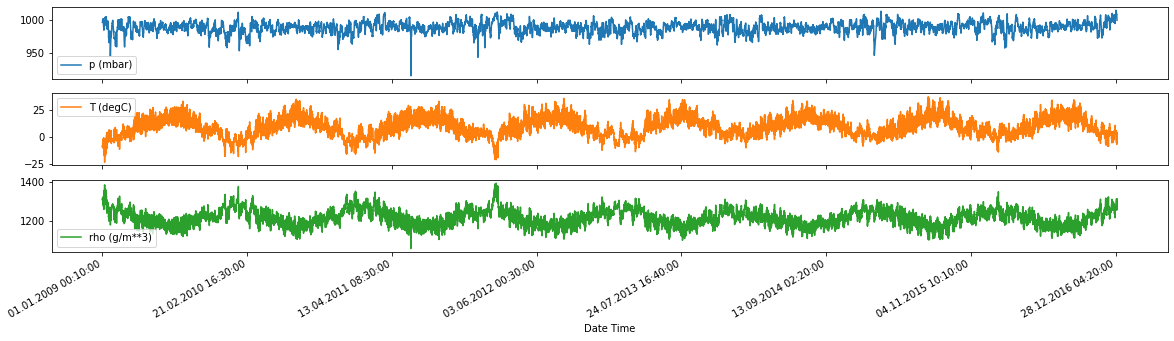

In [7]:
data_df.plot(subplots=True, figsize=(20,5))

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, multi_step=False):
    # function to create input for multivariate time series forecasting
    # and ouput values for 1 step or multistep forecasting, all times between now target_size
    # añado el segundo parametro que es la feature que quiero predecir, la columna entera
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, 1) # step used here.
        data.append(dataset[indices])
        if multi_step: # single_step used here.
            labels.append(target[i:i+target_size]) 
        else:
            labels.append(target[i+target_size])
        
    return np.array(data), np.array(labels)

In [9]:
# First 80% obs will be used as train data and rest as test data.
TRAIN_SPLIT = int(0.8*data_df.shape[0]) 

#From DataFrame to array
data = data_df.values

# Normalize data
train_mean = data[:TRAIN_SPLIT].mean()
train_std = data[:TRAIN_SPLIT].std()
data = (data-train_mean)/train_std

In [10]:
# Use the above function to create the datasets.
# Creating the time windows
past_history = 120  # using 120 hours historical data
future_target = 12  # we want to predict 6 hours in the future


x_train_3D, y_train = multivariate_data(data, data[:, 1], 0, TRAIN_SPLIT,
                                        past_history,
                                        future_target, multi_step=True)
x_val_3D, y_val = multivariate_data(data, data[:, 1], TRAIN_SPLIT, None,
                                    past_history,
                                    future_target, multi_step=True)

In [11]:
x_val_3D.shape, y_val.shape

((13887, 120, 3), (13887, 12))

In [12]:
x_train_3D.shape, y_train.shape

((55953, 120, 3), (55953, 12))

<a name="id1"></a>
## LSTM 1x32N

Multistep

In [13]:
# Building a 1 layer 32 neurons LSTM model
# 12 neurons output this time
simple_lstm_model = Sequential()
simple_lstm_model.add(LSTM(32, input_shape=x_train_3D.shape[-2:]))
simple_lstm_model.add(Dense(12))

simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae']) 


In [32]:
nEpochs = 50
batchSize = 32
call_stop_early = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
calls = [call_stop_early, call_model_checkp]
    
history=simple_lstm_model.fit(x_train_3D, y_train, 
                              epochs=nEpochs, batch_size=batchSize, 
                              verbose=1,
                              validation_data = (x_val_3D, y_val),
                              callbacks=calls)

Epoch 1/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.3924e-05 - mae: 0.0037 - val_loss: 2.3497e-05 - val_mae: 0.0037
Epoch 2/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.3177e-05 - mae: 0.0037 - val_loss: 1.9131e-05 - val_mae: 0.0033
Epoch 3/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.2635e-05 - mae: 0.0036 - val_loss: 1.9187e-05 - val_mae: 0.0033
Epoch 4/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.2851e-05 - mae: 0.0036 - val_loss: 2.0192e-05 - val_mae: 0.0034
Epoch 5/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.3142e-05 - mae: 0.0037 - val_loss: 2.3081e-05 - val_mae: 0.0036
Epoch 6/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.2431e-05 - mae: 0.0036 - val_loss: 2.3604e-05 - val_mae: 0.0037
Epoch 7/50
1749/1749 [==============================] - 12s 7ms/step - loss: 2.2444e-05 - mae: 0.0036 - val_loss: 1.9849e-05 - val_mae: 0.0034

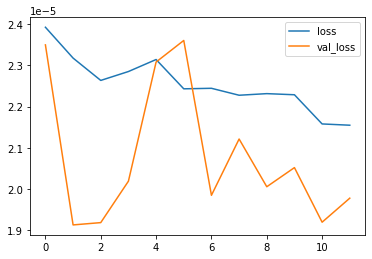

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.show()

In [34]:
#NN model accuracy 
ypred = simple_lstm_model.predict(x_train_3D)
yhat = simple_lstm_model.predict(x_val_3D)

print("\nLSTM NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat))



LSTM NN model

Training accuracy:  0.9251537171554092
Test accuracy:  0.9173599402684758


In [35]:
yhat_n = yhat * train_std + train_mean
y_val_n = y_val * train_std + train_mean

## Accuracy Visualization: 1st way

We visualize here 3000 samples of temperature predicted 1h before, 2h before, etc..

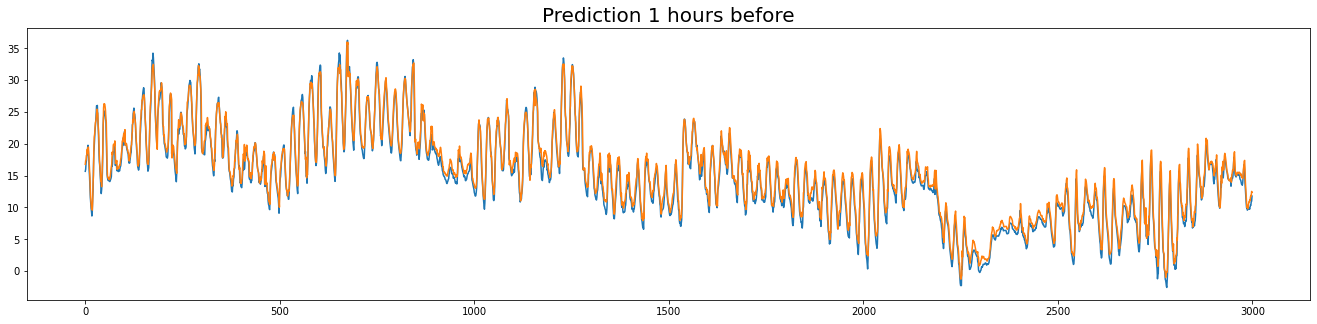

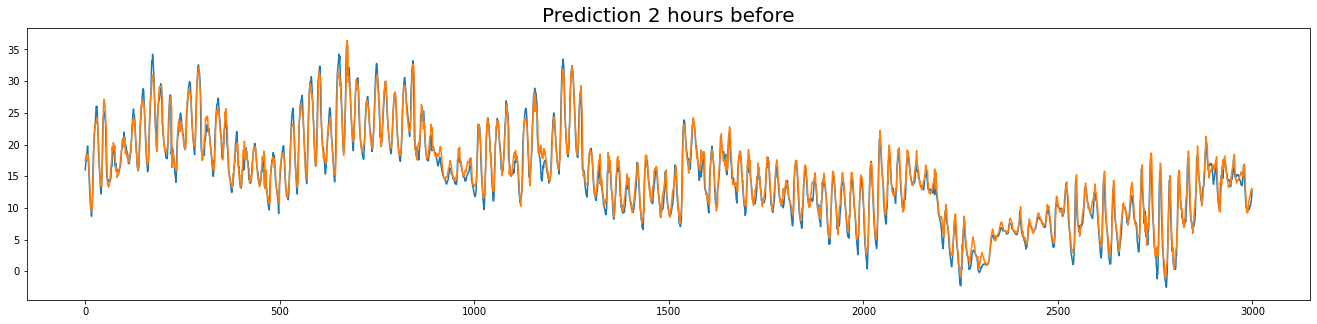

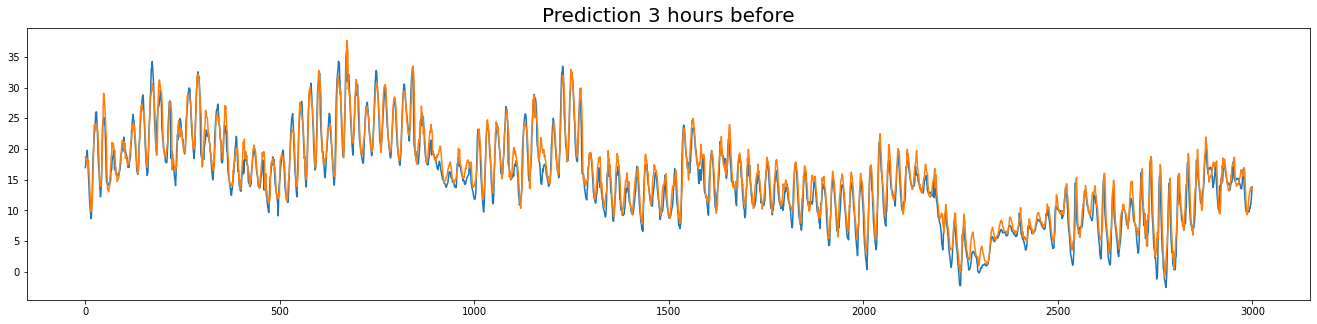

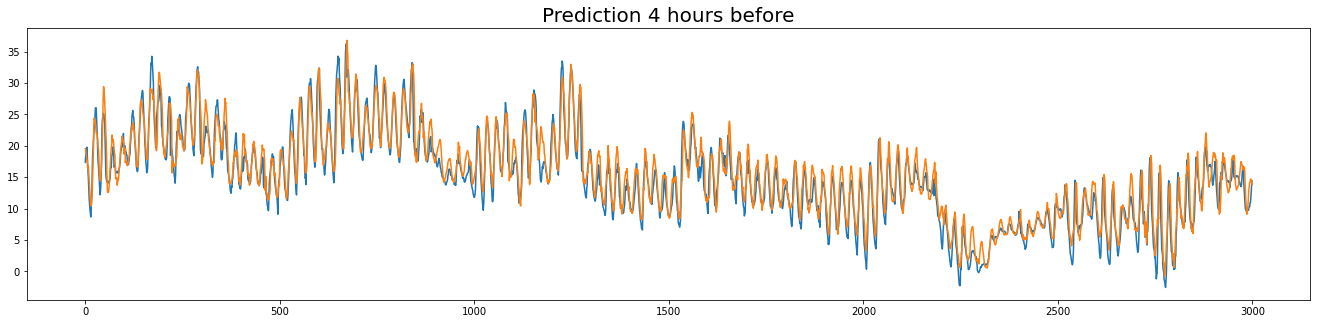

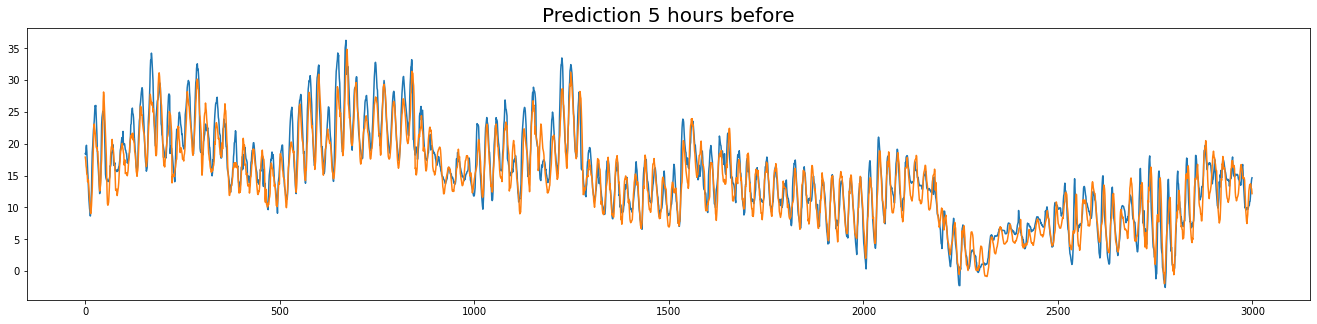

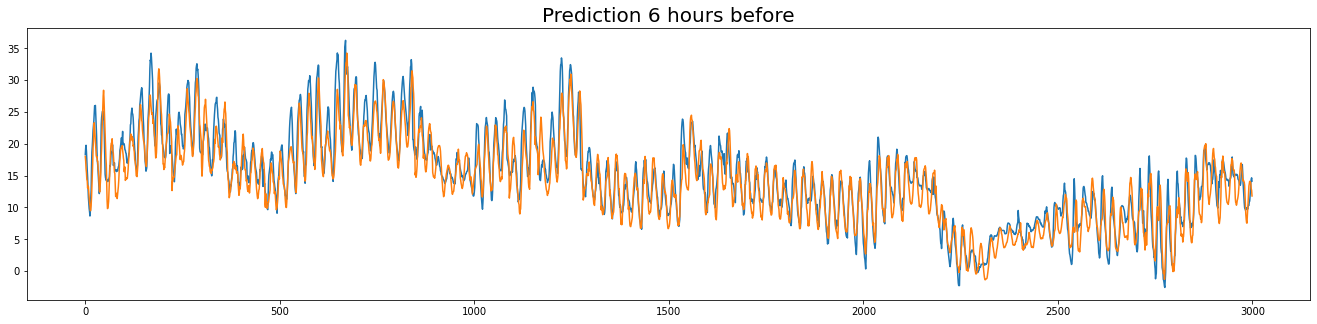

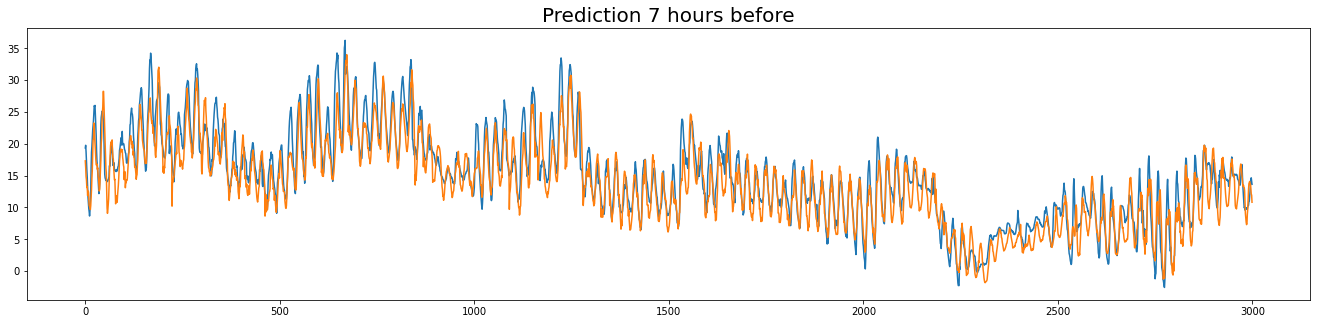

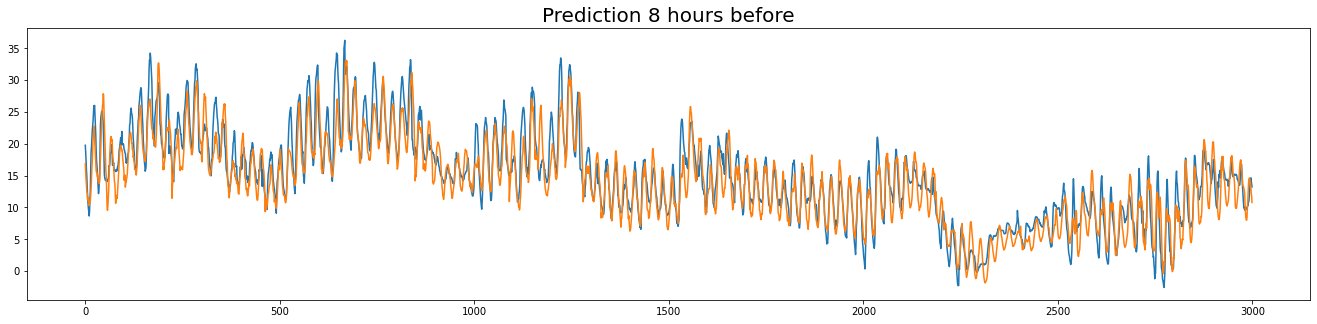

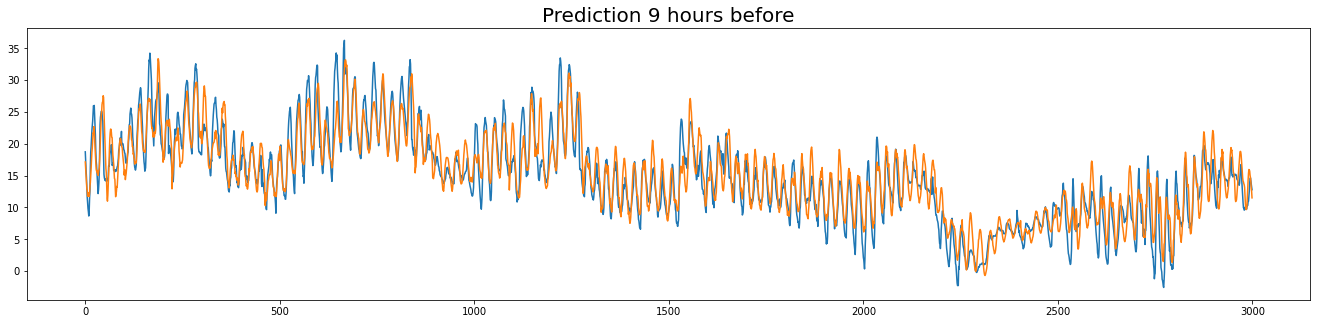

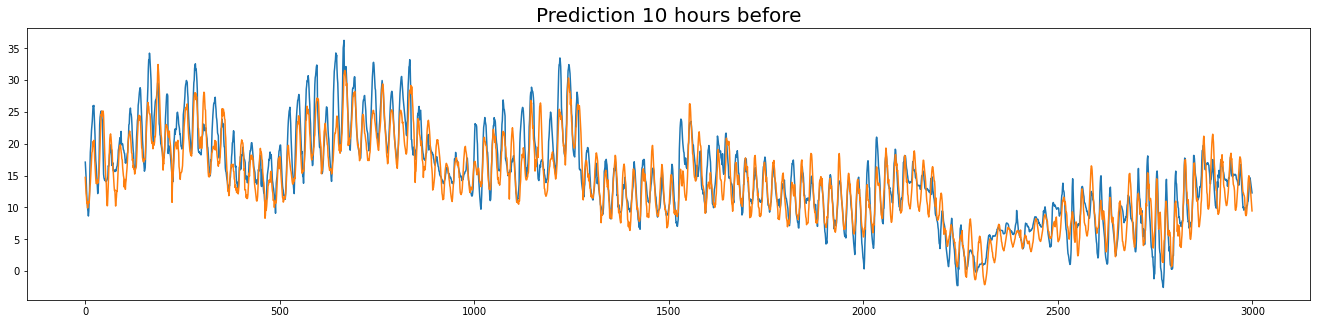

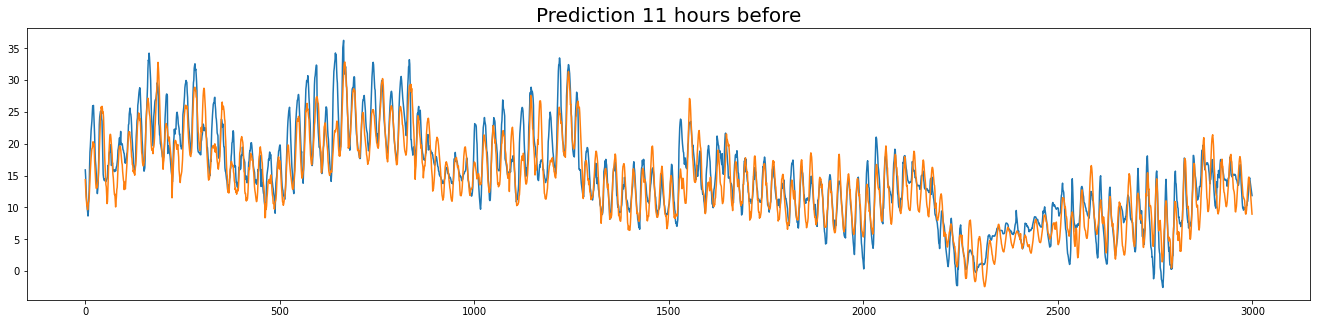

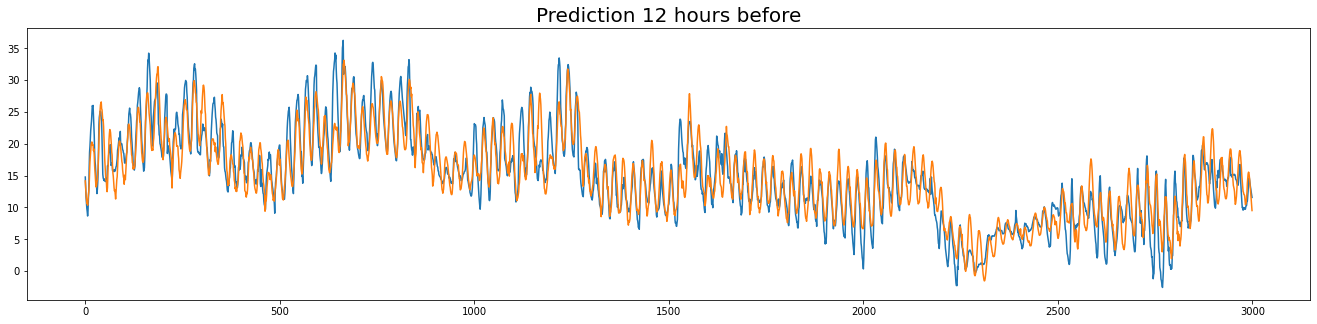

In [36]:
for i in range(0,future_target):
    tit = f"Prediction {i+1} hours before"
    plt.figure(figsize=(23,5))
    plt.plot(y_val_n[1000:4000,i])
    plt.plot(yhat_n[1000:4000,i])
    plt.title(tit,fontsize=20)
    

In [37]:
for i in range(0,future_target):  
    print("Test accuracy",i+1,"hours before: %.2f %%" % (r2_score(y_val_n[:,i], yhat_n[:,i])*100))


Test accuracy 1 hours before: 98.36 %
Test accuracy 2 hours before: 97.65 %
Test accuracy 3 hours before: 95.09 %
Test accuracy 4 hours before: 94.10 %
Test accuracy 5 hours before: 92.86 %
Test accuracy 6 hours before: 91.18 %
Test accuracy 7 hours before: 89.25 %
Test accuracy 8 hours before: 89.40 %
Test accuracy 9 hours before: 89.34 %
Test accuracy 10 hours before: 88.07 %
Test accuracy 11 hours before: 87.48 %
Test accuracy 12 hours before: 88.04 %


## Accuracy Visualization: 2nd way

We visualize here just 6 points of temperature where we show the next 12h prediction against the real temp that will ocurr

In [38]:
#utility function used for ploting
def create_time_steps(length):
  return list(range(-length, 0))
print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [39]:
#plotting function
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.grid()
    plt.plot(num_in, history[:,1], label='History')
    plt.plot(np.arange(num_out), true_future, 'b', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), prediction, 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()


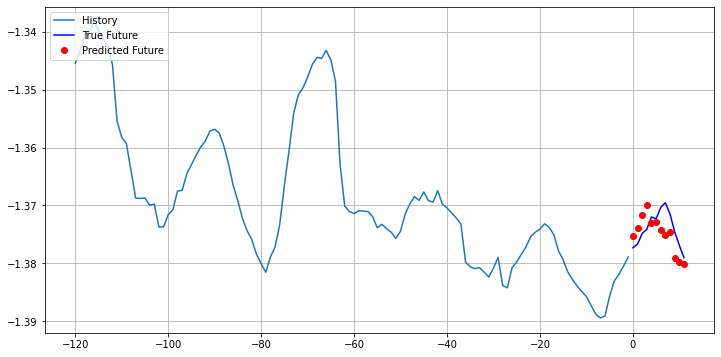

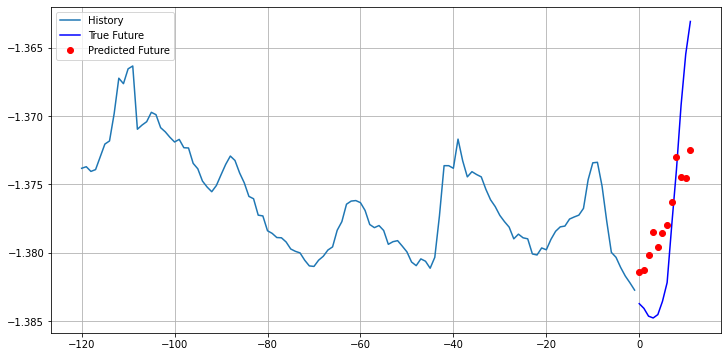

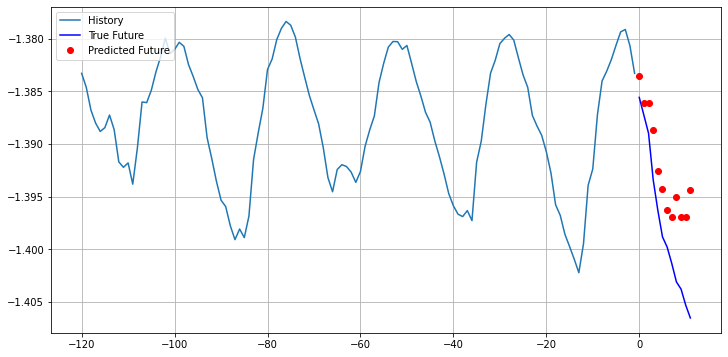

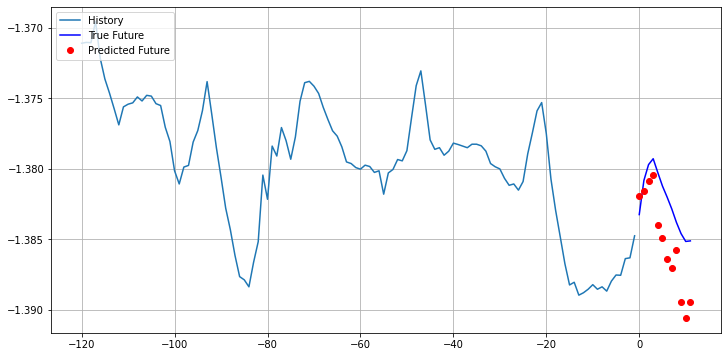

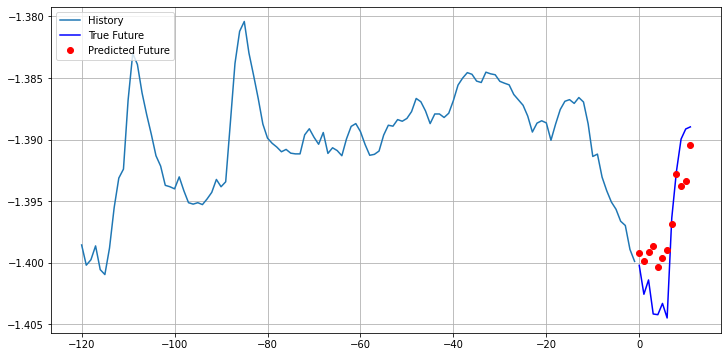

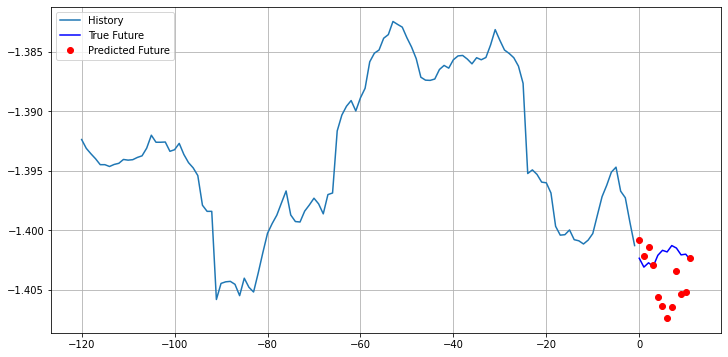

In [40]:
# Plot of 5 points determined by the indices, can be changed to see others
indices=[1000,2000,3000,4000,5000,6000]
x = x_val_3D.take(indices,axis=0)
y1= y_val.take(indices,axis=0)
y2=simple_lstm_model.predict(x)


for i in range(0,len(indices)):
    multi_step_plot(x[i], y1[i], y2[i])

<a name="id2"></a>
## NN densa 1x32N

#### En Multistep no puedo usar mis funciones, porque en Classif uso softmax al final y en Regression solo tengo 1 salida

In [ ]:
# Antes de meterlo a cualquiera de mis funciones hay que aplanar la entrada porque tiene una dim más
# Sirve si aplano las 2 ultimas dimensiones para meterlo en una red Dense
train_flat = x_train_3D.reshape(x_train_3D.shape[0], x_train_3D.shape[1]*x_train_3D.shape[2])
test_flat = x_val_3D.reshape(x_val_3D.shape[0], x_val_3D.shape[1]*x_val_3D.shape[2])

In [ ]:
epochs_ini=50
batch_ini=64

call_stop_early = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
calls = [call_stop_early, call_model_checkp]
    
model = Sequential()
    
# Capa de entrada
model.add(Dense(16, input_dim = train_flat.shape[1], activation='tanh'))
# Capa de salida  
model.add(Dense(12))
model.compile(optimizer = 'adam', loss='mse', metrics=['mae']) 
    
#Hago el entrenamiento/fit mostrando precision entren y test
hist = model.fit(train_flat, y_train,
                    epochs=epochs_ini, batch_size=batch_ini, 
                    validation_data = (test_flat, y_val), 
                    verbose=1,
                    #class_weight = class_weight,
                    callbacks=calls)


Epoch 1/50
875/875 [==============================] - 2s 2ms/step - loss: 0.0370 - mae: 0.0618 - val_loss: 3.0129e-04 - val_mae: 0.0138
Epoch 2/50
875/875 [==============================] - 2s 2ms/step - loss: 2.7880e-04 - mae: 0.0133 - val_loss: 2.5295e-04 - val_mae: 0.0124
Epoch 3/50
875/875 [==============================] - 2s 2ms/step - loss: 2.2909e-04 - mae: 0.0119 - val_loss: 2.0436e-04 - val_mae: 0.0111
Epoch 4/50
875/875 [==============================] - 2s 2ms/step - loss: 1.9426e-04 - mae: 0.0109 - val_loss: 1.5470e-04 - val_mae: 0.0096
Epoch 5/50
875/875 [==============================] - 2s 2ms/step - loss: 1.4127e-04 - mae: 0.0093 - val_loss: 1.2289e-04 - val_mae: 0.0086
Epoch 6/50
875/875 [==============================] - 2s 2ms/step - loss: 1.0708e-04 - mae: 0.0081 - val_loss: 7.6748e-05 - val_mae: 0.0069
Epoch 7/50
875/875 [==============================] - 2s 2ms/step - loss: 7.2241e-05 - mae: 0.0067 - val_loss: 7.6466e-05 - val_mae: 0.0070
Epoch 8/50
875/875 [====

In [ ]:
#NN model accuracy 
ypred = model.predict(train_flat)
yhat = model.predict(test_flat)

print("\nLSTM NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat))




LSTM NN model

Training accuracy:  0.895714430749956
Test accuracy:  0.8898749156462354


In [ ]:
yhat_n = yhat * train_std + train_mean
y_val_n = y_val * train_std + train_mean

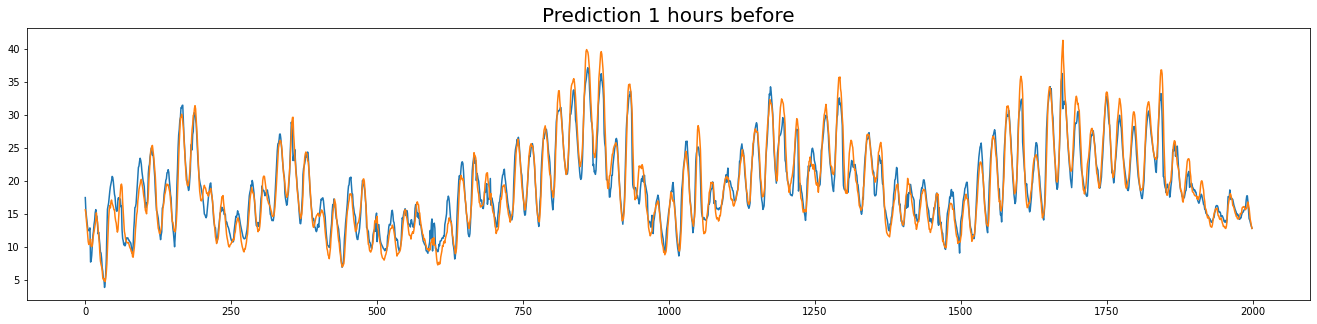

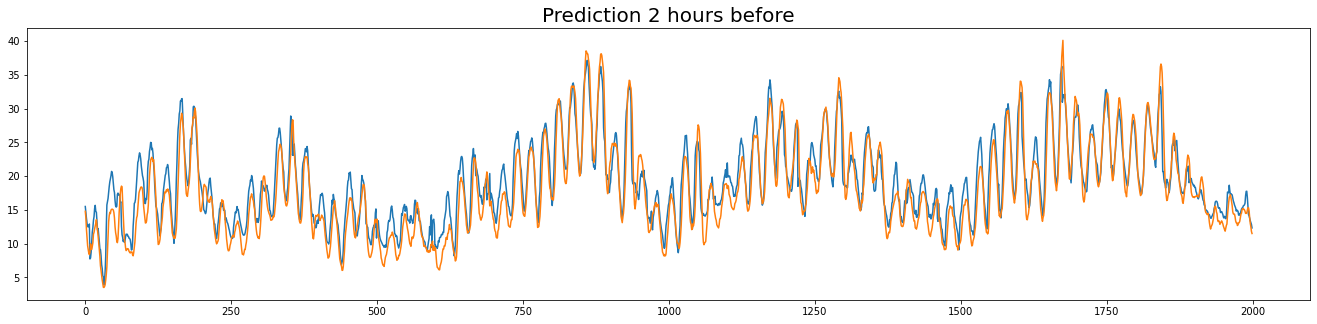

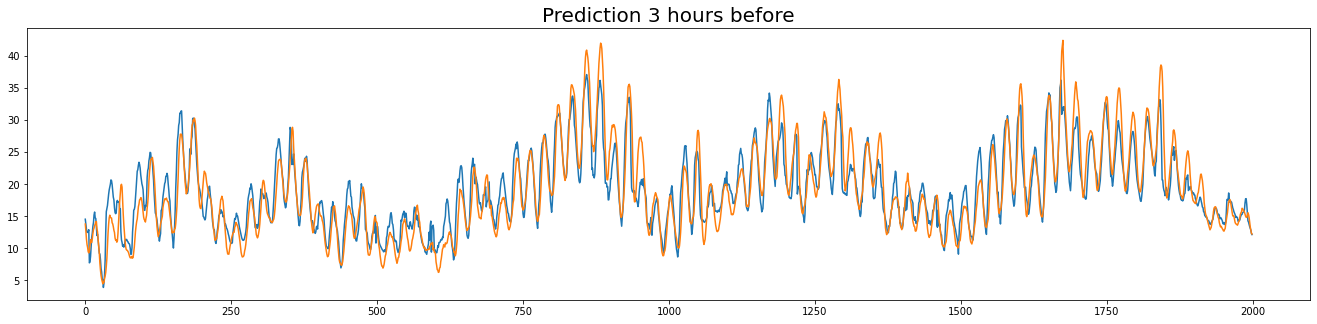

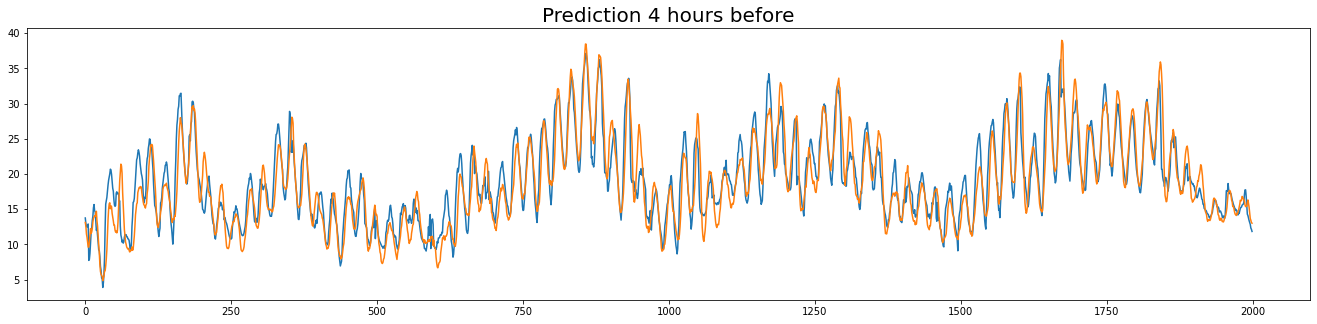

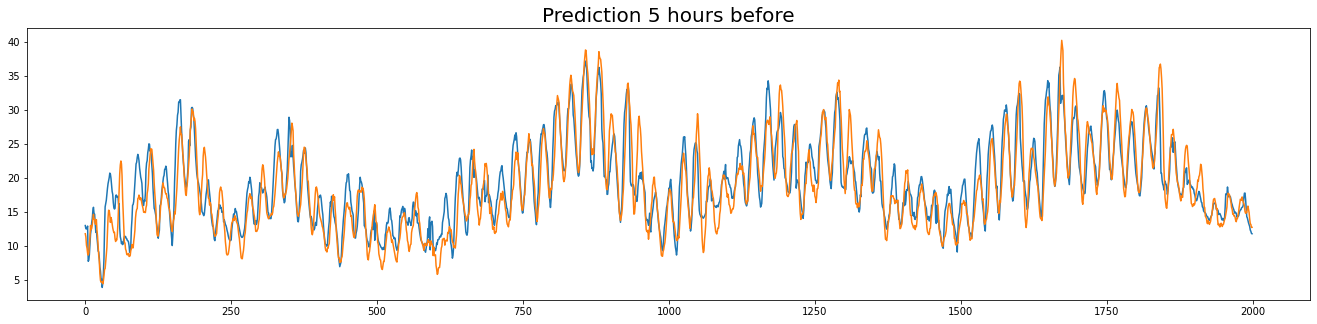

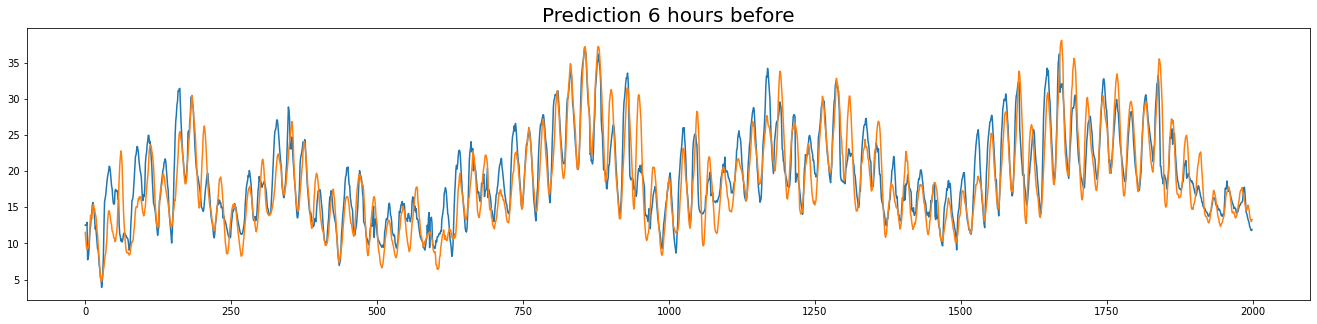

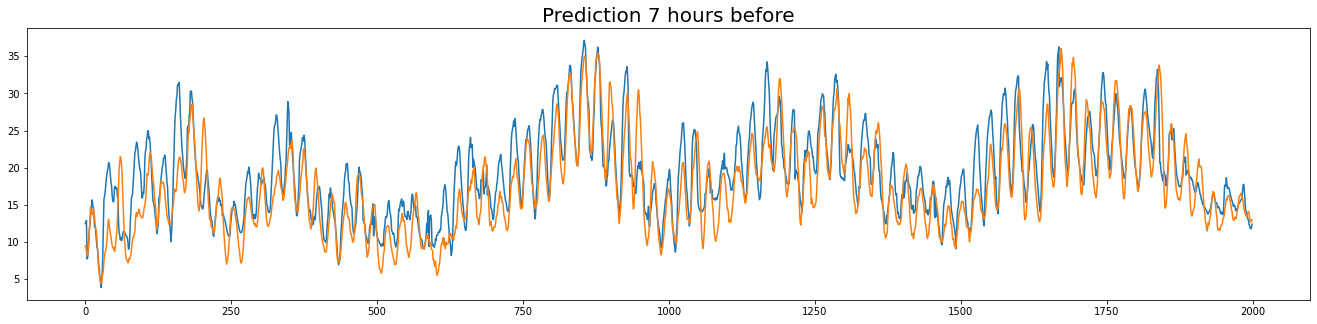

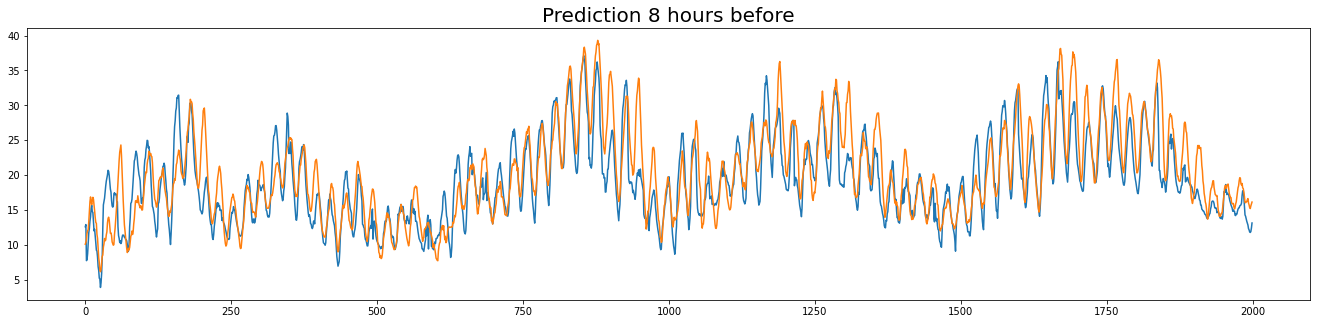

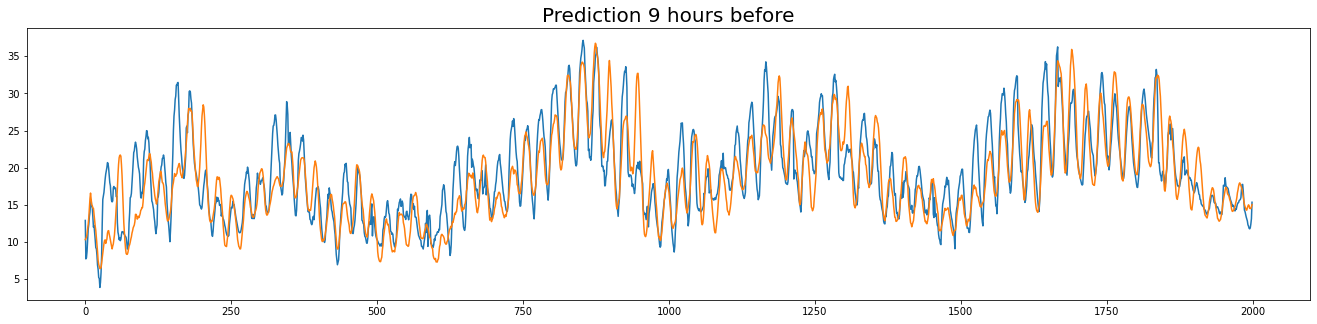

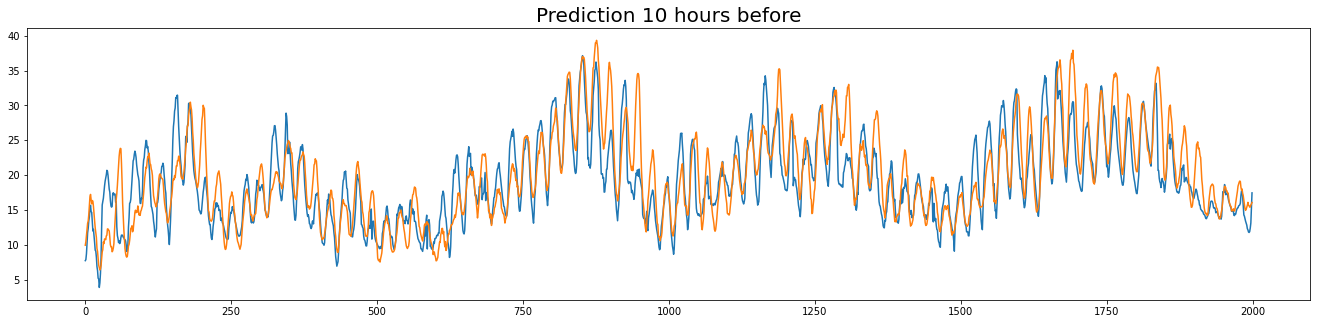

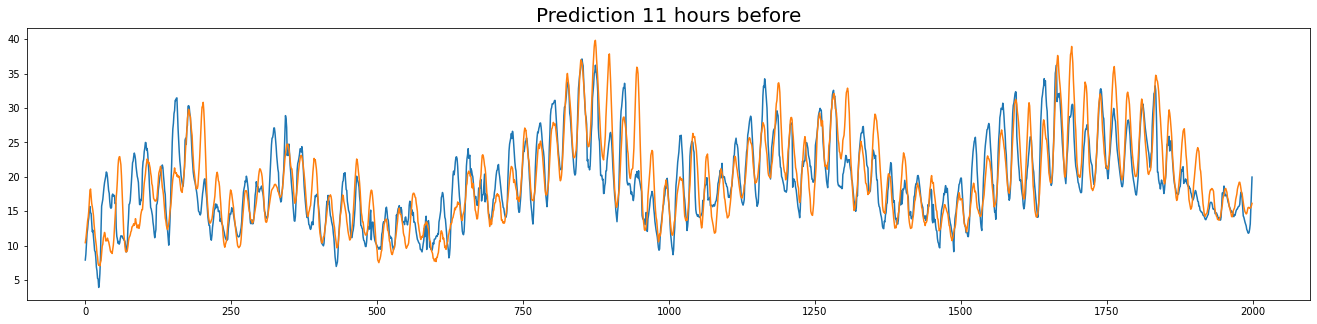

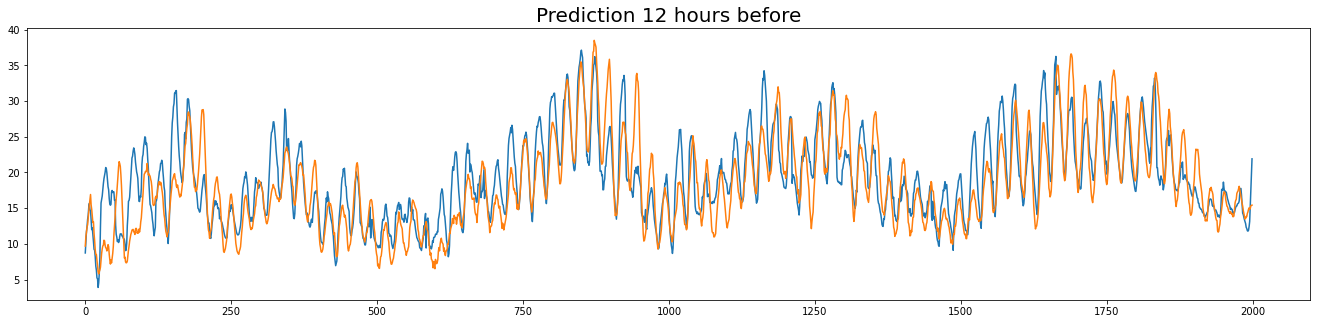

In [ ]:
for i in range(0,future_target):
    tit = f"Prediction {i+1} hours before"
    plt.figure(figsize=(23,5))
    plt.plot(y_val_n[1000:4000,i])
    plt.plot(yhat_n[1000:4000,i])
    plt.title(tit,fontsize=20)

In [ ]:
for i in range(0,future_target):  
    print("Test accuracy",i+1,"hours before: %.2f %%" % (r2_score(y_val_n[:,i], yhat_n[:,i])*100))


Test accuracy 1 hours before: 96.36 %
Test accuracy 2 hours before: 91.28 %
Test accuracy 3 hours before: 91.48 %
Test accuracy 4 hours before: 92.24 %
Test accuracy 5 hours before: 89.97 %
Test accuracy 6 hours before: 89.69 %
Test accuracy 7 hours before: 85.21 %
Test accuracy 8 hours before: 87.27 %
Test accuracy 9 hours before: 87.17 %
Test accuracy 10 hours before: 86.42 %
Test accuracy 11 hours before: 86.53 %
Test accuracy 12 hours before: 84.23 %


<a name="id3"></a>
# LSTM 3x128

In [ ]:
# Construyo el modelo con 2 capas LSTM
# Lo unico a tener en cuenta es que la siguiente necesita la secuencia temporal completa
# por tanto hay que poner el parametro return_sequences=True
layered_lstm_model = Sequential()
layered_lstm_model.add(LSTM(128, input_shape=x_train_3D.shape[-2:], return_sequences=True))
layered_lstm_model.add(LSTM(128, return_sequences=True))
layered_lstm_model.add(LSTM(128, return_sequences=False))
layered_lstm_model.add(Dense(12))

layered_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae']) 


In [ ]:
nEpochs = 100
batchSize = 256
call_stop_early = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
calls = [call_stop_early, call_model_checkp]
    
lhistory=layered_lstm_model.fit(x_train_3D, y_train, 
                              epochs=nEpochs, batch_size=batchSize, 
                              verbose=1,
                              validation_data = (x_val_3D, y_val),
                              callbacks=calls)

Epoch 1/100
219/219 [==============================] - 9s 41ms/step - loss: 1.9332e-05 - mae: 0.0034 - val_loss: 1.9198e-05 - val_mae: 0.0035
Epoch 2/100
219/219 [==============================] - 9s 41ms/step - loss: 1.8538e-05 - mae: 0.0033 - val_loss: 2.3570e-05 - val_mae: 0.0039
Epoch 3/100
219/219 [==============================] - 9s 41ms/step - loss: 1.7249e-05 - mae: 0.0031 - val_loss: 1.6698e-05 - val_mae: 0.0030
Epoch 4/100
219/219 [==============================] - 9s 41ms/step - loss: 1.7780e-05 - mae: 0.0032 - val_loss: 1.5719e-05 - val_mae: 0.0029
Epoch 5/100
219/219 [==============================] - 9s 41ms/step - loss: 1.7844e-05 - mae: 0.0032 - val_loss: 1.6515e-05 - val_mae: 0.0030
Epoch 6/100
219/219 [==============================] - 9s 40ms/step - loss: 1.7982e-05 - mae: 0.0032 - val_loss: 2.4447e-05 - val_mae: 0.0040
Epoch 7/100
219/219 [==============================] - 9s 40ms/step - loss: 1.6930e-05 - mae: 0.0031 - val_loss: 1.5881e-05 - val_mae: 0.0030
Epoch 

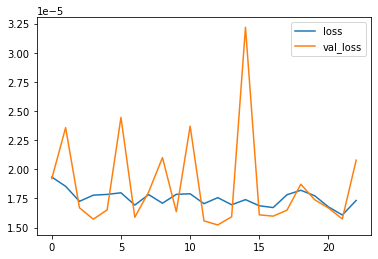

In [ ]:
plt.plot(lhistory.history['loss'])
plt.plot(lhistory.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.show()

In [ ]:
#NN model accuracy 
lypred = layered_lstm_model.predict(x_train_3D)
lyhat = layered_lstm_model.predict(x_val_3D)

print("\nLSTM NN model\n")
print("Training accuracy: ", r2_score(y_train, lypred))
print("Test accuracy: ", r2_score(y_val, lyhat))



LSTM NN model

Training accuracy:  0.9230139703833279
Test accuracy:  0.9131860364673791


In [ ]:
# Undo the normalization to plot the real temperature 
lyhat_n = lyhat * train_std + train_mean
y_val_n = y_val * train_std + train_mean

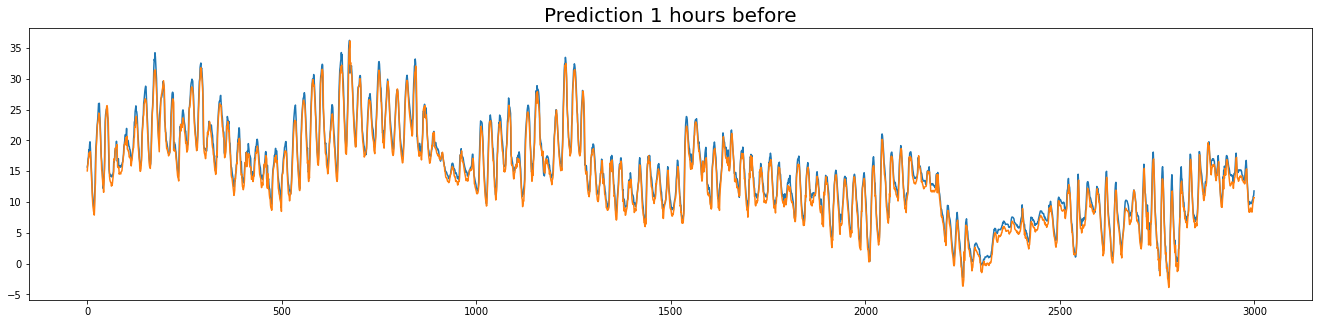

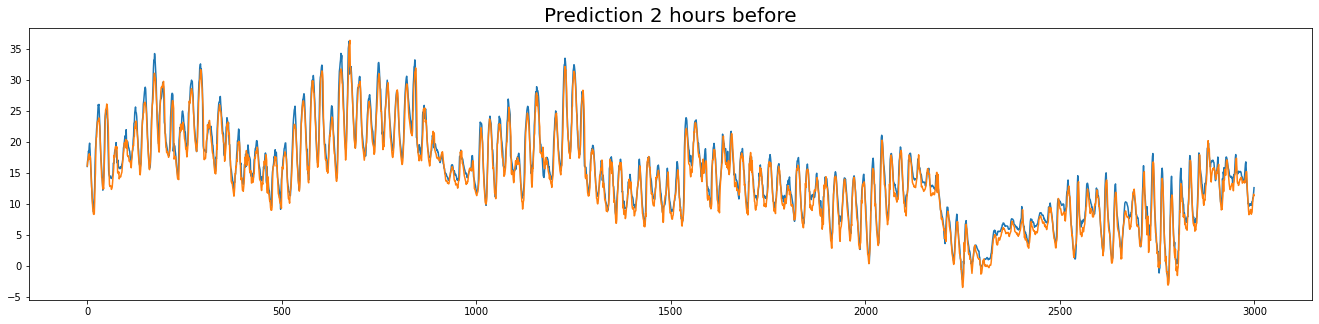

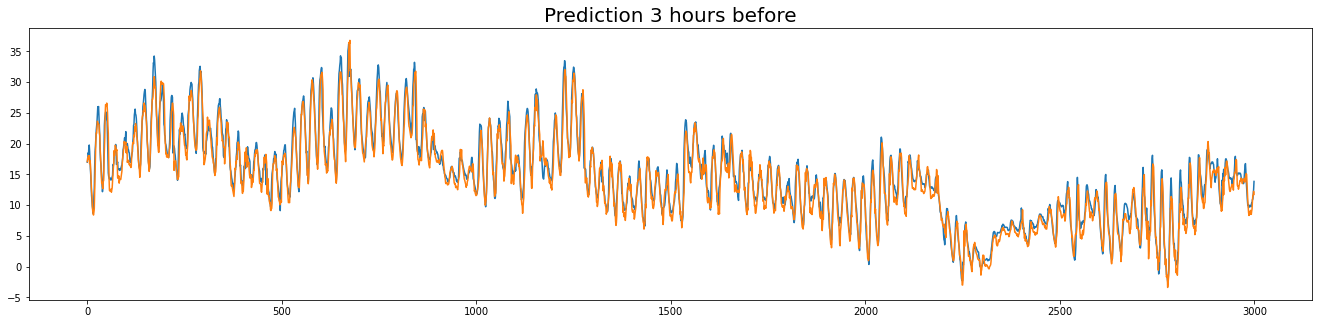

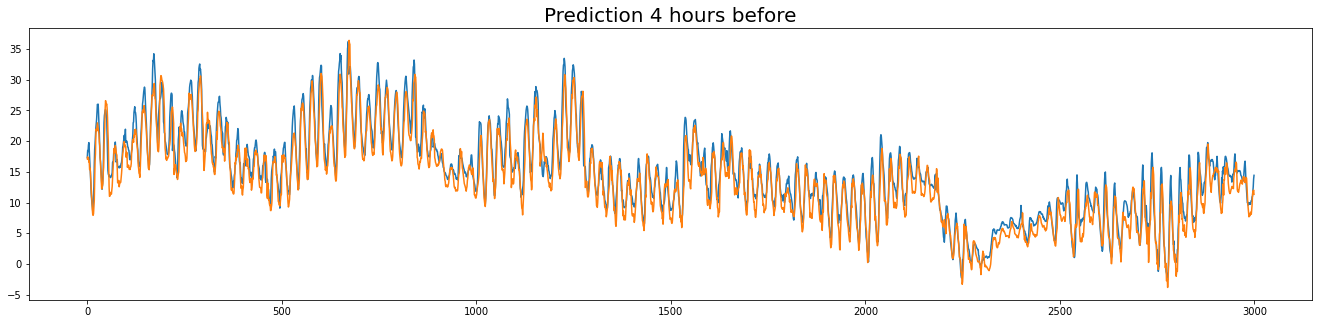

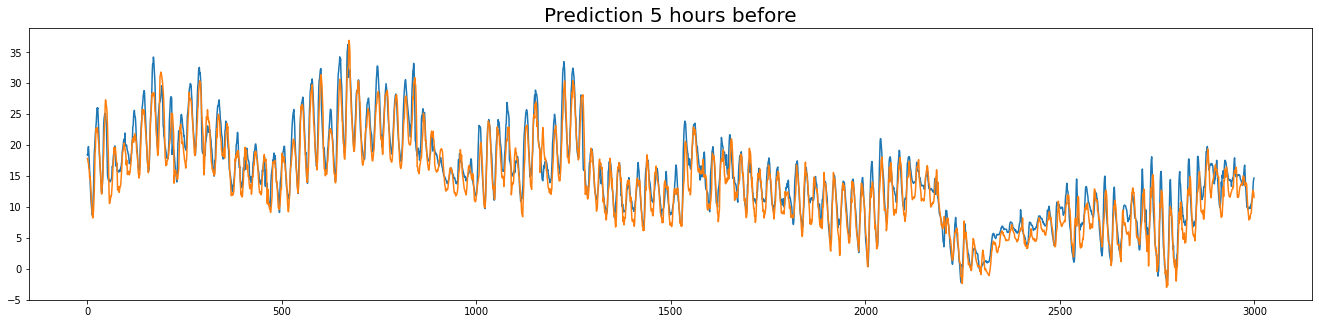

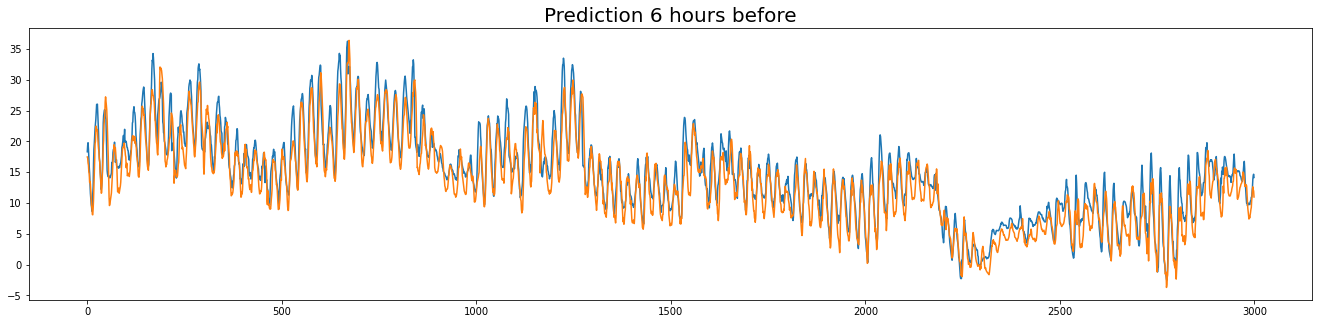

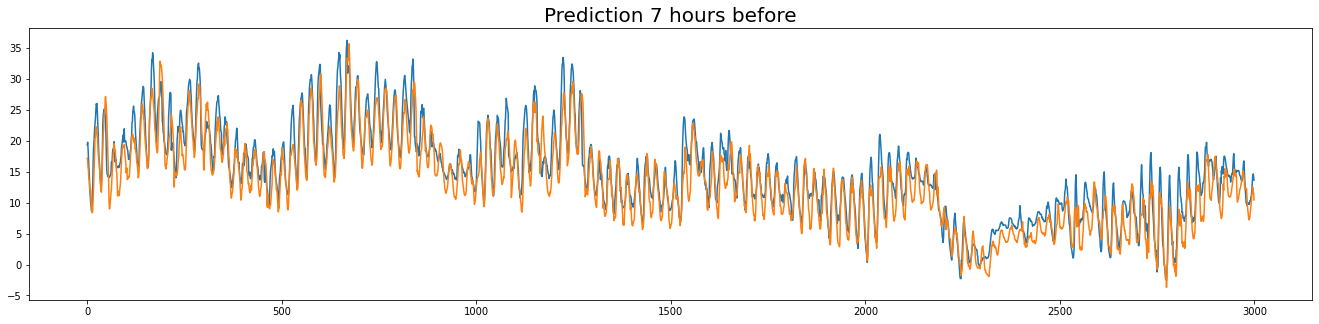

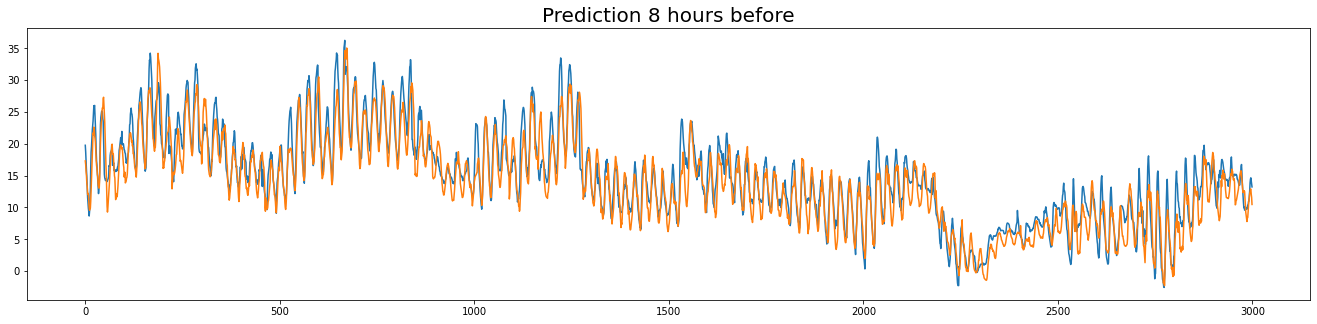

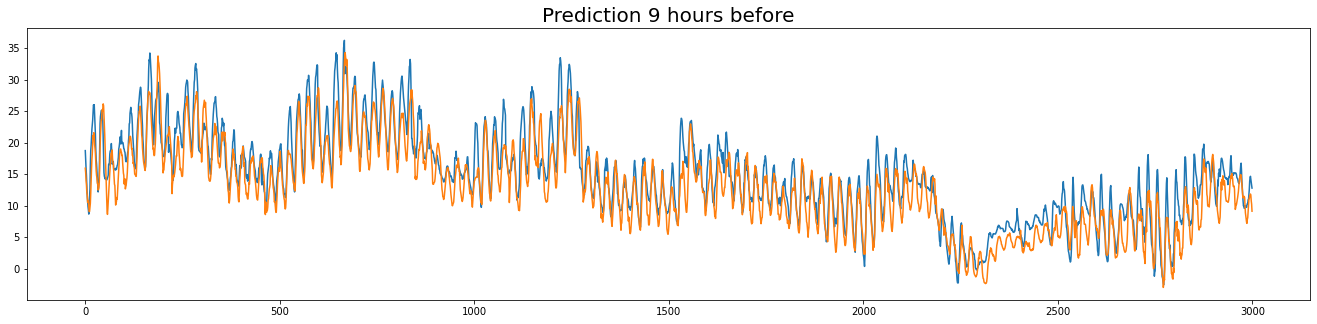

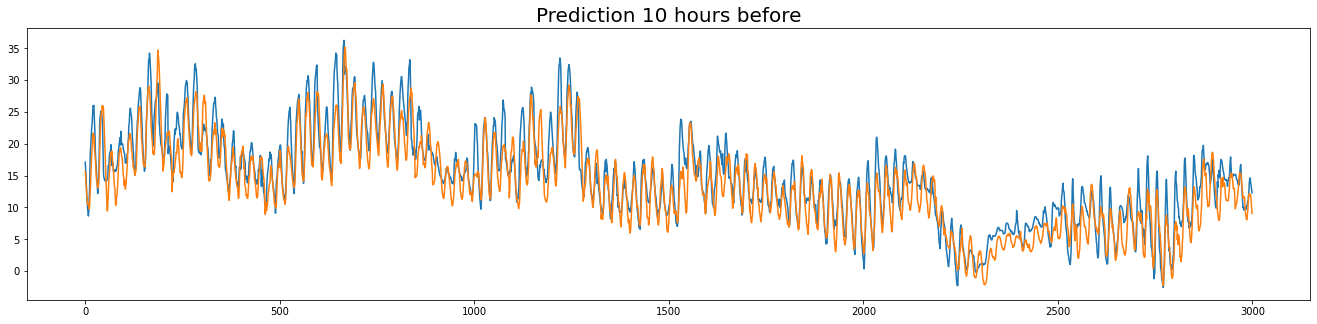

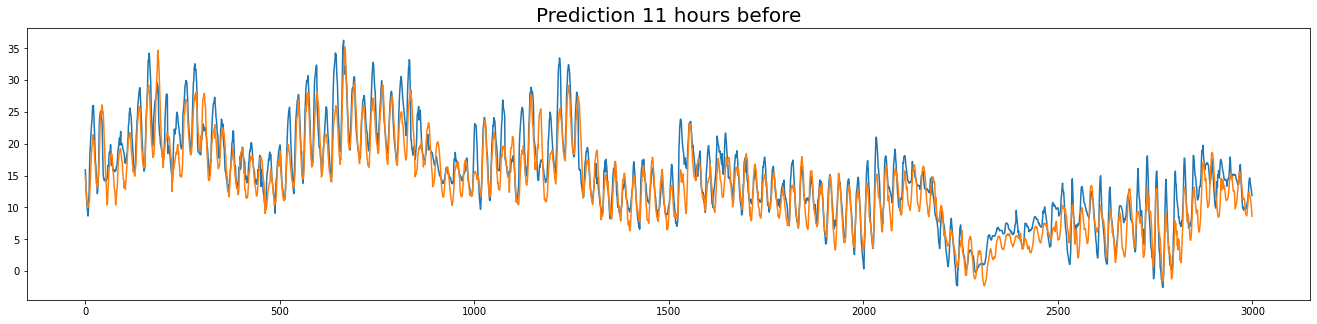

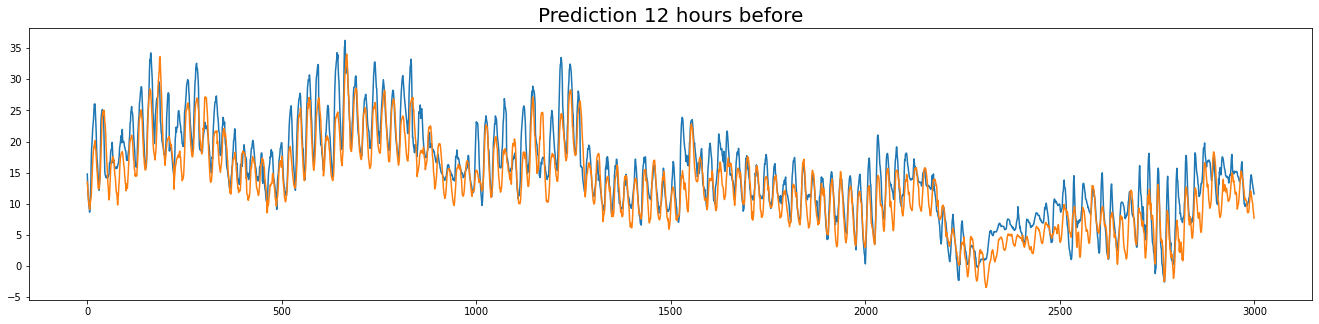

In [ ]:
for i in range(0,future_target):
    tit = f"Prediction {i+1} hours before"
    plt.figure(figsize=(23,5))
    plt.plot(y_val_n[1000:4000,i])
    plt.plot(lyhat_n[1000:4000,i])
    plt.title(tit,fontsize=20)

In [ ]:
for i in range(0,future_target):  
    print("Precisión de test a ",i+1,"horas: %.2f %%" % (r2_score(y_val_n[:,i], lyhat_n[:,i])*100))


Precisión de test a  1 horas: 97.83 %
Precisión de test a  2 horas: 97.10 %
Precisión de test a  3 horas: 96.40 %
Precisión de test a  4 horas: 93.61 %
Precisión de test a  5 horas: 93.32 %
Precisión de test a  6 horas: 90.81 %
Precisión de test a  7 horas: 89.20 %
Precisión de test a  8 horas: 90.64 %
Precisión de test a  9 horas: 86.58 %
Precisión de test a  10 horas: 88.11 %
Precisión de test a  11 horas: 87.76 %
Precisión de test a  12 horas: 84.46 %


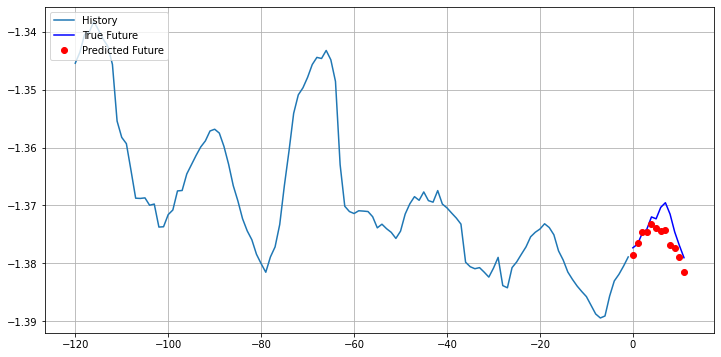

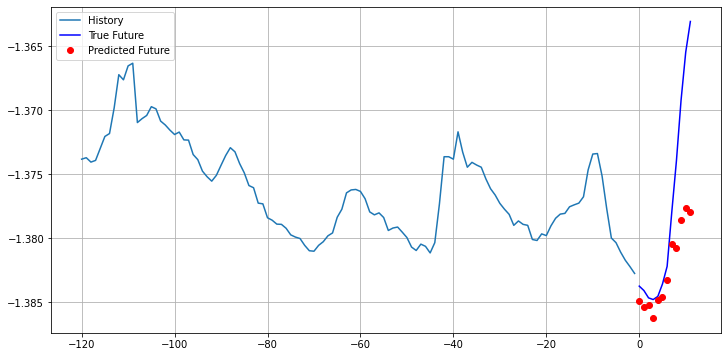

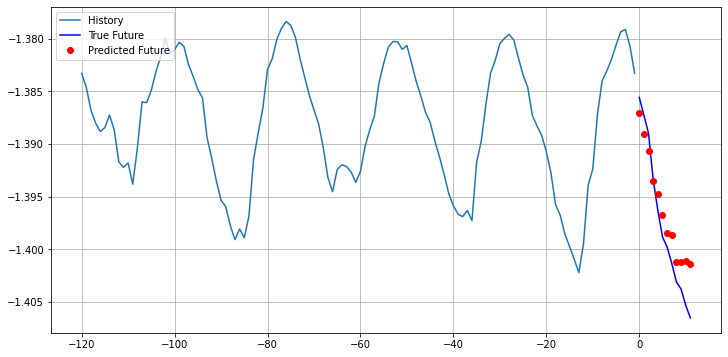

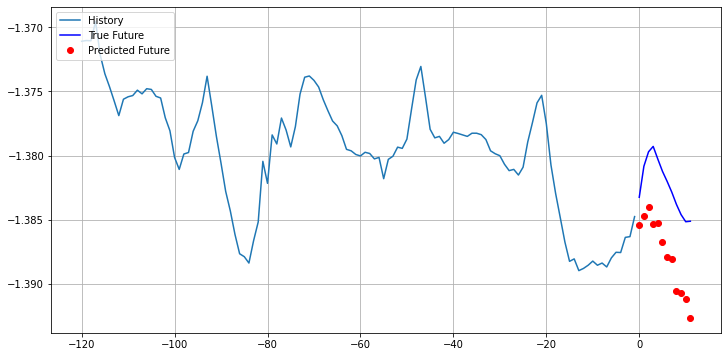

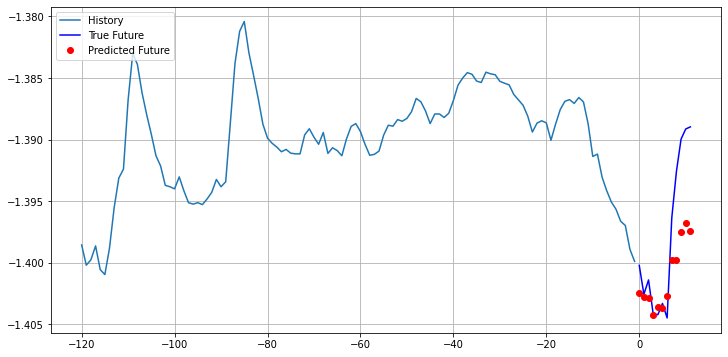

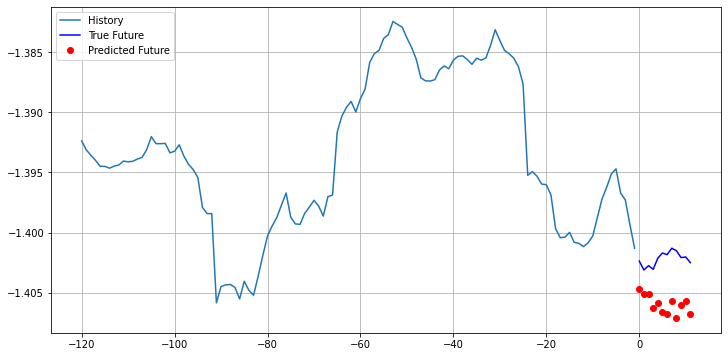

In [ ]:
# Plot of 5 points determined by the indices, can be changed to see others
indices=[1000,2000,3000,4000,5000,6000]
x = x_val_3D.take(indices,axis=0)
y1= y_val.take(indices,axis=0)
y2=layered_lstm_model.predict(x)


for i in range(0,len(indices)):
    multi_step_plot(x[i], y1[i], y2[i])

[retorno al principio](#id8)